# 评估模型
---

## 概要
---

这里我们将执行两个建模任务：回归和分类。我们将展示如何 在TensorFlow 算法中评估模型。

## 回归模型
---

回归模型来自上一节。我们将生成以 Normal（mean = 1，sd = 0.1）和目标数据或重复10.0值分发的输入数据。该模型将优化乘法因子（理论上= 10）来预测目标数据。

## 分类模型
---

分类模型将为 normal(mean = -1, sd = 1) 的一半值和 normal(mean = 2, sd = 1) 的一半值，在这分布中会有一些重叠。分类模型将对预测中间点进行优化，中间点可以既是分类界限。

## 大纲
---

这个想法是我们想将标记的数据集分成训练和测试集。然后我们对测试集进行训练，并查看测试集的准确性。

## 分类结果
---

这是分类结果可视化的直方图：
![]()

正文
---

这段代码将实现两个模型。第一个是一个简单的回归模型，我们将在训练期间展示如何调用损失函数MSE，并在测试和训练集之后输出。

第二个模型将是一个简单的分类模型。我们还将展示如何打印测试和训练集分类的百分比。

### 回归模型

对于回归模型，我们将从 normal（mean = 1，sd = 0.1）生成100个随机样本。目标将是一个大小为100的数组，目标值为10.0。

我们将拟合线性模型 $y = A \cdot x$（没有 y 截距）。 A的理论值为10.0。

加载必要的库并重置计算图。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

启动图会话：

In [2]:
sess = tf.Session()

声明批量大小（batch size）：

In [3]:
batch_size = 25

## 生成回归数据

这里我们生成回归所需的数据。我们还指定必要的占位符。

然后我们将数据分解成 80-20 训练-测试切分。

In [4]:
# 生成数据
x_vals = np.random.normal(1, 0.1, 100)
y_vals = np.repeat(10., 100)
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 切分数据为 训练/测试集 = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

## 模型变量和操作

我们创建模型变量 A 和乘法操作。

In [5]:
# 创建模型变量 A
A = tf.Variable(tf.random_normal(shape=[1, 1]))

# 添加操作到图
my_output = tf.matmul(x_data, A)

## 损失，优化函数，和变量初始化

我们使用 L2 损失函数，标准梯度下降优化，学习率为0.02。

In [6]:
# 添加 L2 损失函数到图
loss = tf.reduce_mean(tf.square(my_output - y_target))

# 创建优化器
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

## 运行回归

我们通过培训步骤迭代100次，每次选择一批随机数据。

In [7]:
# Run Loop
for i in range(100):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = np.transpose([x_vals_train[rand_index]])
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%25==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #25 A = [[ 6.70642376]]
Loss = 12.4879
Step #50 A = [[ 8.85753441]]
Loss = 2.52929
Step #75 A = [[ 9.65153217]]
Loss = 1.24485
Step #100 A = [[ 9.94890499]]
Loss = 1.15033


## 评估回归模型

对回归模型评估，我们将运行训练和测试集的损失。

In [8]:
# Evaluate accuracy (loss) on test set
mse_test = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_test]), y_target: np.transpose([y_vals_test])})
mse_train = sess.run(loss, feed_dict={x_data: np.transpose([x_vals_train]), y_target: np.transpose([y_vals_train])})
print('MSE on test:' + str(np.round(mse_test, 2)))
print('MSE on train:' + str(np.round(mse_train, 2)))

MSE on test:0.68
MSE on train:1.17


## 分类例子

对分类模型，我们生成如下数据：

输入数据是从 normal(mean = -1, sd = 1) 和 normal(mean = 1, sd = 1) 中各采样 50 个数据。

目标数据是 50 个 0 和 50 个 1。

我们拟合二进制分类模型：

- 如果 $sigmoid(x + A) < 0.5$，我们推断为 0
- 吐过 $sigmoid(x + A) >= 0.5$，我们推断为 1

理论上 A 应该是：

$$- \frac{mean1 + mean2}{2} = 0$$

好了，现在重置图：

In [9]:
ops.reset_default_graph()

创建图会话：

In [10]:
sess = tf.Session()

声明批量大小：

In [11]:
batch_size = 25

## 生成分类数据和目标数据

我们如上所述生成分类数据。然后我们创建必要的占位符。

然后，我们切分数据为 80-20 训练/测试集。

In [12]:
# Create data
x_vals = np.concatenate((np.random.normal(-1, 1, 50), np.random.normal(2, 1, 50)))
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50)))
x_data = tf.placeholder(shape=[1, None], dtype=tf.float32)
y_target = tf.placeholder(shape=[1, None], dtype=tf.float32)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

## 模型变量和操作

我们创建模型变量 A 和模型操作，它是将 A 添加到输入数据。请注意，我们不将 sigmoid() 函数放在这里，因为它将被包含在损失函数中。这也意味着对于预测，我们将需要包含 sigmoid 函数。

In [13]:
# Create variable (one model parameter = A)
A = tf.Variable(tf.random_normal(mean=10, shape=[1]))

# Add operation to graph
# Want to create the operstion sigmoid(x + A)
# Note, the sigmoid() part is in the loss function
my_output = tf.add(x_data, A)

## 损失，优化函数，和变量初始化

损失函数选用 sigmoid-cross-entropy。我们使用 reduce_mean() 来封装损失函数以便在全批次数据中减少 sigmoid-cross-entropy。

我们使用的优化函数仍是标准梯度下降优化，学习率为0.05。

In [15]:
# Add classification loss (cross entropy)
xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target))

# Create Optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

## 运行分类

我们迭代 1800 次分类训练操作，并且每200次迭代一次打印出 A 值和损失值。

In [16]:
# Run loop
for i in range(1800):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = [x_vals_train[rand_index]]
    rand_y = [y_vals_train[rand_index]]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    if (i+1)%200==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x_data: rand_x, y_target: rand_y})))

Step #200 A = [ 7.01122999]
Loss = 3.31835
Step #400 A = [ 2.73941112]
Loss = 0.354624
Step #600 A = [ 0.50843418]
Loss = 0.316609
Step #800 A = [-0.10985172]
Loss = 0.330854
Step #1000 A = [-0.23218325]
Loss = 0.299426
Step #1200 A = [-0.23459852]
Loss = 0.260422
Step #1400 A = [-0.26495484]
Loss = 0.227307
Step #1600 A = [-0.2499817]
Loss = 0.206538
Step #1800 A = [-0.29281732]
Loss = 0.273244


## 评估分类结果

Accuracy on train set: 0.925
Accuracy on test set: 1.0


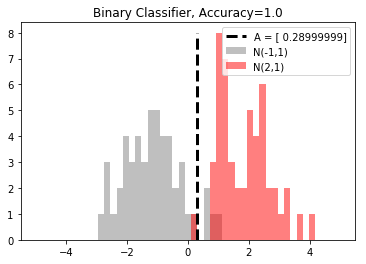

In [20]:
# Evaluate Predictions on test set
y_prediction = tf.squeeze(tf.round(tf.nn.sigmoid(tf.add(x_data, A))))
correct_prediction = tf.equal(y_prediction, y_target)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_value_test = sess.run(accuracy, feed_dict={x_data: [x_vals_test], y_target: [y_vals_test]})
acc_value_train = sess.run(accuracy, feed_dict={x_data: [x_vals_train], y_target: [y_vals_train]})
print('Accuracy on train set: ' + str(acc_value_train))
print('Accuracy on test set: ' + str(acc_value_test))

# Plot classification result
A_result = -sess.run(A)
bins = np.linspace(-5, 5, 50)
plt.hist(x_vals[0:50], bins, alpha=0.5, label='N(-1,1)', color='gray')
plt.hist(x_vals[50:100], bins[0:50], alpha=0.5, label='N(2,1)', color='red')
plt.plot((A_result, A_result), (0, 8), 'k--', linewidth=3, label='A = '+ str(np.round(A_result, 2)))
plt.legend(loc='upper right')
plt.title('Binary Classifier, Accuracy=' + str(np.round(acc_value_test, 2)))
plt.show()